In [1]:
import pixelator

import os
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [48]:
# Setup
DATA_DIR = Path('./datasets')

# Dataset: https://software.pixelgen.com/datasets/technote-mpx-v1-vs-v2
# PBMC cells extracted from a healthy volunteer. Half were fixed and half were stimulated into PHA blasts ("activation". in this state the cells rapidly divide).
baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
!curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample05_V2_PBMC_r1.layout.dataset.pxl"
pg_data = pixelator.read(DATA_DIR / "Sample05_V2_PBMC_r1.layout.dataset.pxl")
adata_obs = pg_data.adata.obs
adata_var = pg_data.adata.var
adata_X = pg_data.adata.X
adata_df = pg_data.adata.to_df()

** Resuming transfer from byte position 969731508
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


In [3]:
print(pg_data.adata)
print(pg_data.adata.X)

AnnData object with n_obs × n_vars = 1125 × 84
    obs: 'pixels', 'a_pixels', 'b_pixels', 'antibodies', 'molecules', 'reads', 'mean_reads_per_molecule', 'median_reads_per_molecule', 'mean_b_pixels_per_a_pixel', 'median_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'median_a_pixels_per_b_pixel', 'a_pixel_b_pixel_ratio', 'mean_molecules_per_a_pixel', 'median_molecules_per_a_pixel', 'leiden', 'tau_type', 'tau'
    var: 'antibody_count', 'components', 'antibody_pct', 'nuclear', 'control'
    uns: 'neighbors', 'tau_thresholds', 'umap', 'version'
    obsm: 'X_umap', 'clr', 'log1p'
    obsp: 'connectivities', 'distances'
[[4690  349  509 ...   14   22   15]
 [3379   94  262 ...   24   22   12]
 [3070   39  202 ...   17   31   17]
 ...
 [ 329    8   21 ...    1    5    0]
 [ 329   23    1 ...    1    2    0]
 [ 152    2   17 ...    0    1    4]]


In [49]:
# Single outlier with extreme measures of a_pixel
print((adata_obs['a_pixels'] > 20000).sum())
adata_obs = adata_obs.drop(adata_obs[adata_obs['a_pixels'] > 20000].index)

1


True


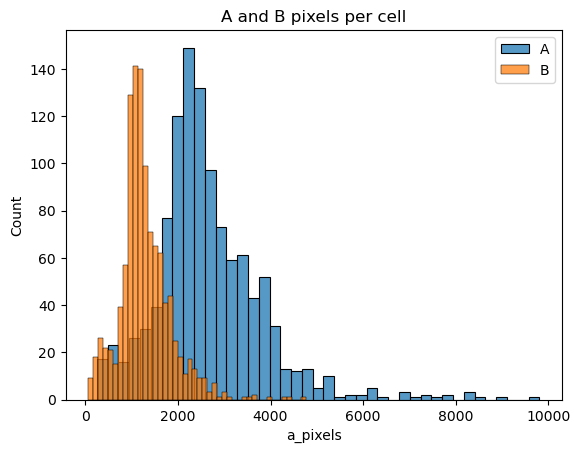

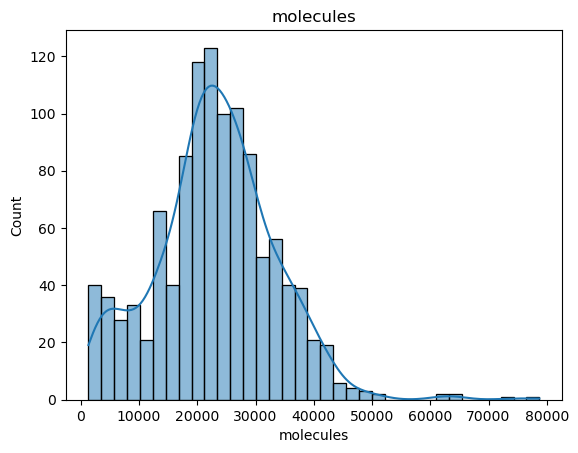

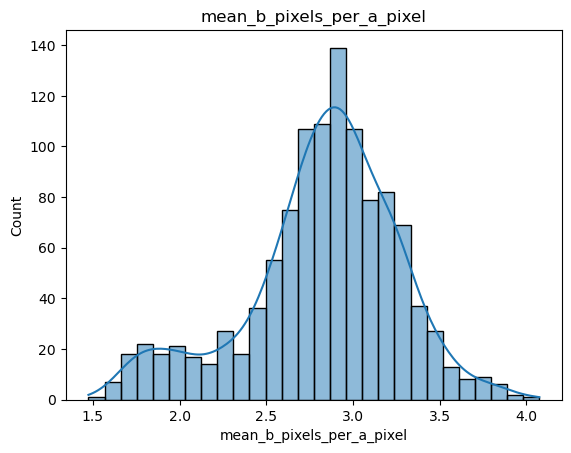

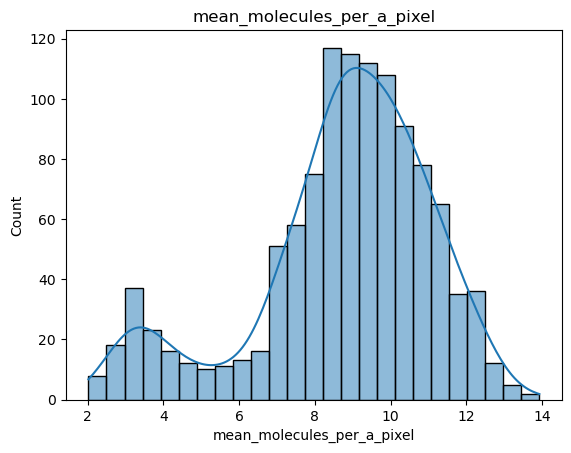

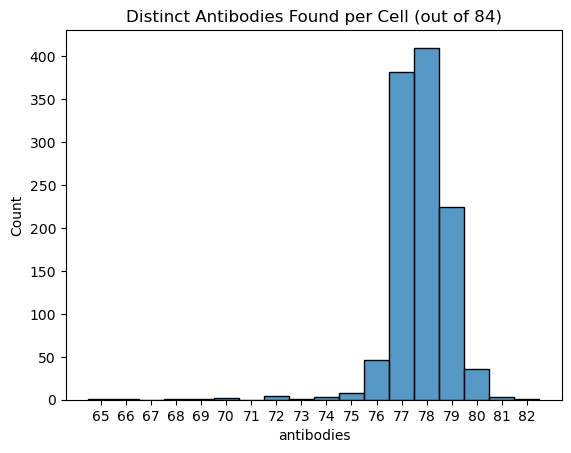

In [5]:
hist_vars = ['a_pixels', 'b_pixels', 'molecules', 'mean_b_pixels_per_a_pixel', 'mean_molecules_per_a_pixel', 'antibodies']
print(all(adata_obs['pixels'] ==  adata_obs['a_pixels'] + adata_obs['b_pixels']))
for var in hist_vars:
    if var == 'b_pixels':
        continue
    fig, ax = plt.subplots(1)
    if var == 'a_pixels':
        sns.histplot(adata_obs['a_pixels'], ax=ax, label='A')
        sns.histplot(adata_obs['b_pixels'], ax=ax, label='B')
        ax.legend()
        ax.set_title('A and B pixels per cell')
        continue
    if var == 'antibodies':
        sns.histplot(adata_obs['antibodies'], ax=ax, discrete=True)
        ax.set_title('Distinct Antibodies Found per Cell (out of 84)')
        ax.set_xticks(list(range(adata_obs['antibodies'].min(), adata_obs['antibodies'].max() + 1)))
        continue
    sns.histplot(adata_obs[var], kde=True, ax=ax)
    ax.set_title(var)


<Axes: xlabel='a_pixels', ylabel='mean_b_pixels_per_a_pixel'>

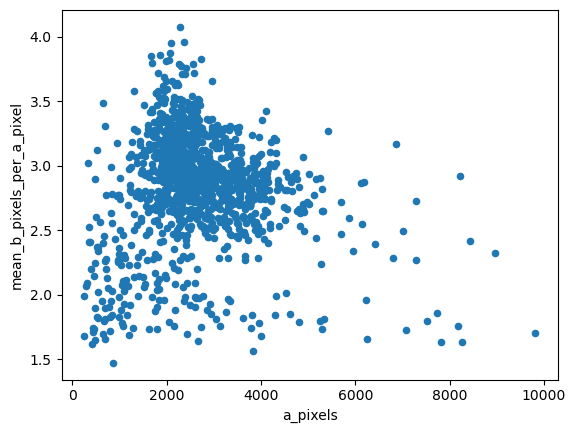

In [6]:
adata_obs = adata_obs.drop(adata_obs[adata_obs['a_pixels'] > 20000].index)
adata_obs.plot.scatter(x='a_pixels', y='mean_b_pixels_per_a_pixel')

In [61]:
antibody_variation_df = pg_data.adata.to_df().aggregate(['mean', 'std']).transpose()
antibody_variation_df['std/mean'] = antibody_variation_df['std'] / antibody_variation_df['mean']

Text(0.5, 1.0, 'Cells per antibody')

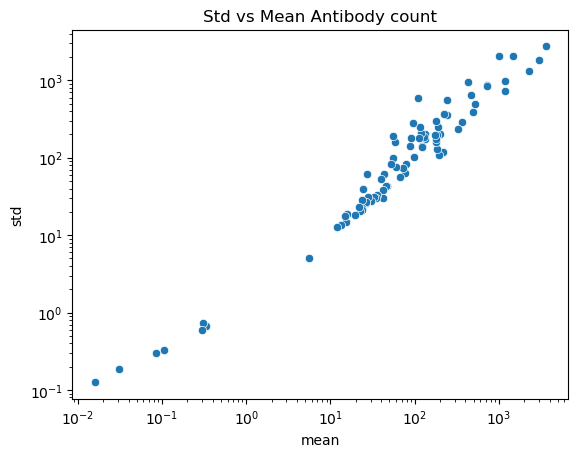

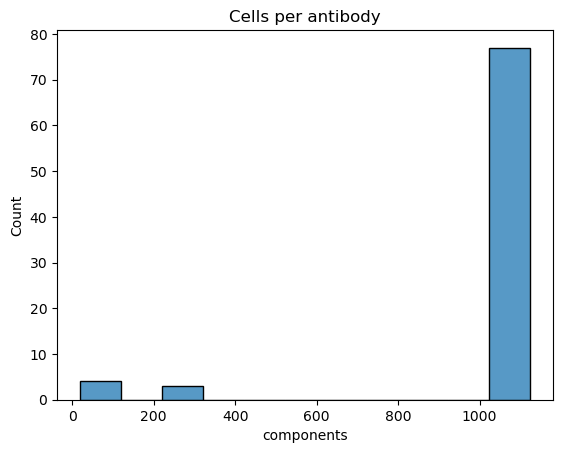

In [76]:
fig, ax = plt.subplots(1)
# sns.histplot(np.log10(adata_var['antibody_count']), ax=ax[0])
# ax[0].set_title('Log10 Total Antibody count')
sns.scatterplot(data=antibody_variation_df, x='mean', y='std')
ax.set_xscale('log')
ax.set_yscale('log')
# sns.histplot(np.log10(adata_df.mean(axis=0)), ax=ax)
ax.set_title('Std vs Mean Antibody count')

# fig, ax = plt.subplots(1)
# sns.histplot(np.log10(adata_var['components']), ax=ax, binwidth=0.25)
# ax.set_title('Log10 cells per antibody')

fig, ax = plt.subplots(1)
sns.histplot(adata_var['components'], ax=ax, binwidth=100)
ax.set_title('Cells per antibody')

# fig, ax = plt.subplots(1)
# antibody_variation = pg_data.adata.X.var(axis=0,)
# sns.histplot(np.log10(antibody_variation), ax=ax)
# ax.set_title('Log10 Antibody Count Variation (across cells)')

In [72]:
# antibody_variation_df.sort_values(by='mean', axis=0, ascending=False, inplace=True)
antibody_variation_df[antibody_variation_df['mean'] < 10].index

Index(['CD123', 'CD94', 'CD192', 'CD335', 'CD58', 'CD39', 'CD191', 'CD180'], dtype='object', name='marker')

In [65]:
# antibody_variation_df.sort_values(by='std', axis=0, ascending=False, inplace=True)
# # var(axis=0).sort_values(ascending=False)
# # antibody_variation_df['']
# print(antibody_variation_df.head(10))
# print(antibody_variation_df.tail(10))

# antibody_variation_df.sort_values(by='std/mean', axis=0, ascending=False, inplace=True)
# print(antibody_variation_df.head(10))
# print(antibody_variation_df.tail(10))



In [66]:
# sns.histplot(adata_df['CD24'])

Text(0.5, 1.0, 'Ab Pairs - Joint Cell Count (Abundance > 10)')

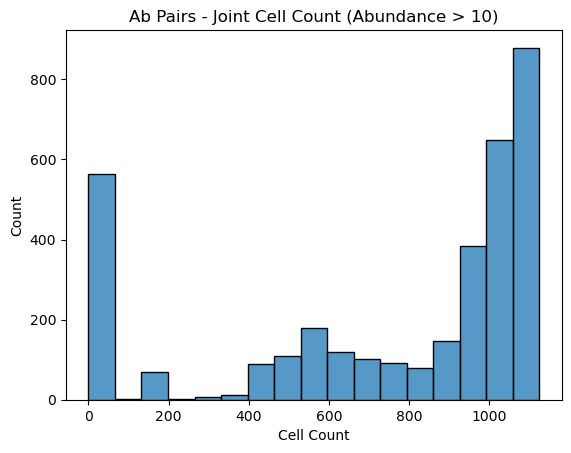

In [107]:
import itertools

adata_corr = adata_df.corr()
n_antibodies = pg_data.adata.X.shape[1]
antibody_pairs_names = list(itertools.combinations(pg_data.adata.var_names, 2))
antibody_pair_count = pd.DataFrame(index=antibody_pairs_names, columns={'Cell Count': pd.Series(dtype=int), 'Corr': pd.Series(dtype=float)})
abundance_thresh = 10
for i, (ab_1, ab_2) in enumerate(antibody_pairs_names):
    name = (ab_1, ab_2)
    antibody_pair_count.at[name, 'Cell Count'] = len(adata_df[(adata_df[ab_1] > abundance_thresh) & (adata_df[ab_2] > abundance_thresh)])
    antibody_pair_count.at[name, 'Corr'] = adata_corr.loc[ab_1, ab_2]

# ax = sns.kdeplot(antibody_pair_count, x='Cell Count', y='Corr')
# ax.set_title('Ab Pairs - Correlation vs Joint Cell Count (Abundance > 10)')

ax = sns.histplot(antibody_pair_count['Cell Count'])
ax.set_title('Ab Pairs - Joint Cell Count (Abundance > 10)')

# protein_pair_count = pg_data.adata.X.copy()
# antibody_pair_count.sort_values(ascending=False).tail(10)


## Key takeaways
1. A large majority of antibodies are present in almost all cells. However some antibodies are present in very low quantities with a mean abundance of less than 10: 'CD123', 'CD94', 'CD192', 'CD335', 'CD58', 'CD39', 'CD191', 'CD180'
2. Most cells have 10K-40K antibodies sequenced
3. Antibody abundance variance grows with mean
4. Antibody pairs could be informative even without spatial information

In [ ]:
# TODO: protein abundance cutoff 10K-50K
# TODO: PCA -> Cell types